In [164]:
import random
from typing import List, Dict

import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import shap
import seaborn as sns

In [2]:
from pandas_utils import DF, ND, S, is_pd
from estimators import ColumnTransformer, BinaryTransformer, OptunaLgbECV

In [117]:
SEED = 31

random.seed(SEED)
np.random.seed(SEED)

In [18]:
# dataset = datasets.load_boston()
dataset = datasets.load_diabetes()
# dataset = datasets.load_breast_cancer()

y = pd.Series(dataset.target)
x = pd.DataFrame(dataset.data, columns=dataset.feature_names)

In [16]:
preprocess = Pipeline(steps=[
    ('label_encode', ColumnTransformer(defs={
        'sex': BinaryTransformer()
    })),
])

In [19]:
x = preprocess.transform(x)

In [ ]:
ecv = OptunaLgbECV(lgb_params=dict(
    objective='regression',
    metric='rmse',
    early_stopping_round=20,
)).fit(x, y)

In [100]:
class FeatureContribution:
    
    def __init__(self, model, x: DF, y: S):
        self.explainer = shap.TreeExplainer(model)
        self.shap_values = self.explainer.shap_values(x)
        self.shap_values_pd = pd.DataFrame(self.shap_values, columns=x.columns, index=x.index)
        self.model = model
        self.x = x
        self.y = y
    
    def dependency_plot(self, feature: str = None):
        if feature is None:
            for f in self.x.columns:
                shap.dependence_plot(f, self.shap_values, self.x)
        else:
            shap.dependence_plot(feature, self.shap_values, self.x)
    
    def force_plot(self, i_sample: int):
        shap.force_plot(
            self.explainer.expected_value,
            self.shap_values[i_sample, :],
            self.x.iloc[i_sample, :],
            matplotlib=True,
        )
    
    def _binary_feature_contrib_shap(self, feature: str, value_from = 0, value_to = 1):
        sv = self.shap_values_pd[feature]
        fv = self.x[feature]
        return sv[fv == value_to].mean() - sv[fv == value_from].mean()
    
    def _binary_feature_contrib_naive(self, feature: str, value_from = 0, value_to = 1):
        fv = self.x[feature]
        return y[fv == value_to].mean() - y[fv == value_from].mean()

In [101]:
fc = FeatureContribution(ecv.models[0], x, y)

In [89]:
fc._binary_feature_contrib_shap('sex')

-10.690329402502876

In [90]:
fc._binary_feature_contrib_naive('sex')

6.645390070921962

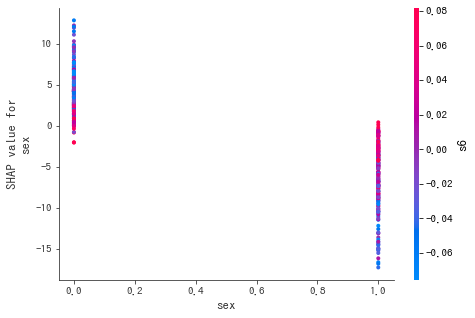

In [91]:
fc.dependency_plot('sex')

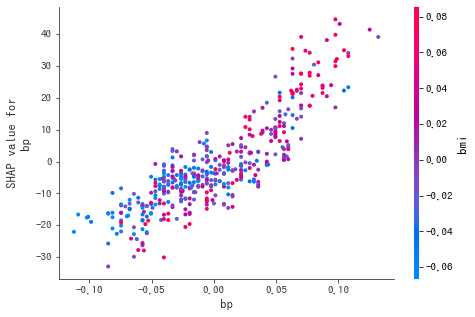

In [92]:
fc.dependency_plot('bp')

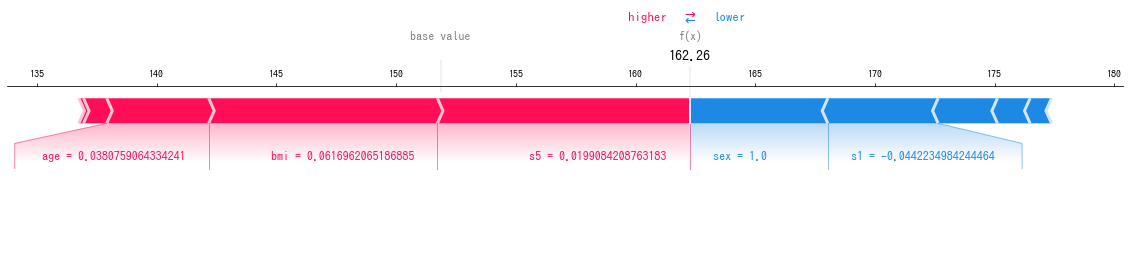

In [97]:
fc.force_plot(0)

In [174]:
def gen_x(n_samples: int = 1000):
    r1 = np.random.uniform(size=n_samples)
    r2 = np.random.uniform(size=n_samples)
    x1, x2 = np.zeros(n_samples), np.zeros(n_samples)
    x1[r1 < 0.3] = 1
    x2[r2 < 0.6] = 1
    x12 = x1 * x2
    x3 = np.random.randn(n_samples)
    return x1, x2, x12, x3

def toy1(n_samples: int = 1000):
    x1, x2, x12, x3 = gen_x(n_samples)
    y_ = x1 * 10 + x2 *20 + x3 * 15 + np.random.randn(n_samples) * 10
    y = StandardScaler().fit_transform(y_[:, np.newaxis]).squeeze()
    x = pd.DataFrame(dict(x1=x1, x2=x2, x12=x12, x3=x3))
    y = pd.Series(y)
    return x, y

def toy2(n_samples: int = 1000):
    x1, x2, x12, x3 = gen_x(n_samples)
    y_ = x1 * 10 + x2 *20 + x3 * 15 + np.random.randn(n_samples) * 10 + 5 * x12
    y = StandardScaler().fit_transform(y_[:, np.newaxis]).squeeze()
    x = pd.DataFrame(dict(x1=x1, x2=x2, x12=x12, x3=x3))
    y = pd.Series(y)
    return x, y

In [175]:
toy1_x, toy1_y = toy1()
toy2_x, toy2_y = toy2()

In [ ]:
ecv_toy1 = OptunaLgbECV(lgb_params=dict(
    objective='regression',
    metric='rmse',
    early_stopping_round=20,
)).fit(toy1_x, toy1_y)

In [ ]:
ecv_toy2 = OptunaLgbECV(lgb_params=dict(
    objective='regression',
    metric='rmse',
    early_stopping_round=20,
)).fit(toy2_x, toy2_y)

In [178]:
fc_toy1 = FeatureContribution(ecv_toy1.models[0], toy1_x, toy1_y)
fc_toy2 = FeatureContribution(ecv_toy2.models[0], toy2_x, toy2_y)

In [179]:
pd.DataFrame([[
    fc_toy1._binary_feature_contrib_shap(c), fc_toy1._binary_feature_contrib_naive(c)
] for c in ['x1', 'x2', 'x12']], columns=['shap', 'naive'], index=['x1', 'x2', 'x12'])

,shap,naive
x1,0.277990,17.232700
x2,0.920875,2.217114
x12,0.195772,9.165015


In [180]:
pd.DataFrame([[
    fc_toy2._binary_feature_contrib_shap(c), fc_toy2._binary_feature_contrib_naive(c)
] for c in ['x1', 'x2', 'x12']], columns=['shap', 'naive'], index=['x1', 'x2', 'x12'])

,shap,naive
x1,0.303235,7.581357
x2,0.886657,6.665501
x12,0.382703,14.875901
